# 이미지 합성 (희귀 클래스 증강)

**목적:** 10개 이하 샘플을 가진 희귀 클래스의 데이터를 증강

**방식:**
- 원본 이미지를 배경으로 사용 (기존 알약 유지)
- 희귀 클래스에서 랜덤 2~4종류 crop → 빈 공간에 배치
- 기존 bbox와 겹치지 않게 배치

In [49]:
import json
import random
import numpy as np
import cv2
from pathlib import Path
from PIL import Image, ImageFilter
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches

PROJECT_ROOT = Path("c:/Users/YJ/Desktop/medicine")
TRAIN_IMG_DIR = PROJECT_ROOT / "data" / "raw" / "train_images"
COCO_JSON = PROJECT_ROOT / "data" / "processed" / "integrated_coco_data.json"

# 통합 COCO 데이터 로드
with open(COCO_JSON, "r", encoding="utf-8") as f:
    coco_data = json.load(f)

print(f"총 이미지 수: {len(coco_data)}")

총 이미지 수: 232


## 1. 클래스별 샘플 수 확인 (희귀 클래스 파악)

In [50]:
# 클래스별 등장 횟수
label_counter = Counter()
for fname, info in coco_data.items():
    for lbl in info["labels"]:
        label_counter[lbl] += 1

# 정렬해서 보기
sorted_labels = sorted(label_counter.items(), key=lambda x: x[1])

print(f"전체 클래스 수: {len(sorted_labels)}")
print(f"\n=== 희귀 클래스 (10개 이하) ===")
rare_classes = []
for lbl, cnt in sorted_labels:
    if cnt <= 10:
        rare_classes.append(lbl)
        print(f"  pill_{lbl}: {cnt}개")

print(f"\n희귀 클래스 수: {len(rare_classes)}개")
print(f"전체 클래스 중 비율: {len(rare_classes)}/{len(sorted_labels)}")

전체 클래스 수: 56

=== 희귀 클래스 (10개 이하) ===
  pill_27993: 3개
  pill_12247: 3개
  pill_27777: 3개
  pill_31885: 3개
  pill_34597: 3개
  pill_19552: 3개
  pill_22362: 3개
  pill_12081: 3개
  pill_3743: 3개
  pill_13395: 3개
  pill_16551: 3개
  pill_33208: 3개
  pill_24850: 3개
  pill_21771: 3개
  pill_27926: 3개
  pill_33009: 3개
  pill_29451: 3개
  pill_4543: 5개
  pill_3544: 6개
  pill_19861: 6개
  pill_25438: 6개
  pill_12778: 6개
  pill_29345: 6개
  pill_19607: 6개
  pill_16688: 8개
  pill_30308: 9개
  pill_28763: 9개
  pill_22347: 9개
  pill_2483: 9개

희귀 클래스 수: 29개
전체 클래스 중 비율: 29/56


## 2. 클래스별 crop 추출

In [51]:
def extract_crops_by_class(coco_data, img_dir, target_classes):
    """
    희귀 클래스의 알약을 이미지에서 crop하여 딕셔너리로 반환
    Returns: {class_id: [(crop_img, w, h), ...], ...}
    """
    crops = {cls: [] for cls in target_classes}
    target_set = set(target_classes)

    for fname, info in coco_data.items():
        labels = info["labels"]
        boxes = info["boxes"]

        # 이 이미지에 희귀 클래스가 있는지 확인
        has_rare = any(lbl in target_set for lbl in labels)
        if not has_rare:
            continue

        img_path = img_dir / fname
        if not img_path.exists():
            continue

        img = Image.open(img_path).convert("RGBA")

        for box, lbl in zip(boxes, labels):
            if lbl not in target_set:
                continue

            x1, y1, x2, y2 = map(int, box)
            crop = img.crop((x1, y1, x2, y2))
            crops[lbl].append(crop)

    return crops

# crop 추출
rare_crops = extract_crops_by_class(coco_data, TRAIN_IMG_DIR, rare_classes)

# 결과 확인
total_crops = 0
for cls, crop_list in rare_crops.items():
    total_crops += len(crop_list)
    print(f"pill_{cls}: crop {len(crop_list)}개")
print(f"\n총 crop 수: {total_crops}개")

pill_27993: crop 3개
pill_12247: crop 3개
pill_27777: crop 3개
pill_31885: crop 3개
pill_34597: crop 3개
pill_19552: crop 3개
pill_22362: crop 3개
pill_12081: crop 3개
pill_3743: crop 3개
pill_13395: crop 3개
pill_16551: crop 3개
pill_33208: crop 3개
pill_24850: crop 3개
pill_21771: crop 3개
pill_27926: crop 3개
pill_33009: crop 3개
pill_29451: crop 3개
pill_4543: crop 5개
pill_3544: crop 6개
pill_19861: crop 6개
pill_25438: crop 6개
pill_12778: crop 6개
pill_29345: crop 6개
pill_19607: crop 6개
pill_16688: crop 8개
pill_30308: crop 9개
pill_28763: crop 9개
pill_22347: crop 9개
pill_2483: crop 9개

총 crop 수: 136개


## 3. crop 시각화 (확인용)

C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2950905412.py:15: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2950905412.py:15: UserWarning: Glyph 55148 (\N{HANGUL SYLLABLE HYI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2950905412.py:15: UserWarning: Glyph 44480 (\N{HANGUL SYLLABLE GWI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2950905412.py:15: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2950905412.py:15: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2950905412.py:15: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu 

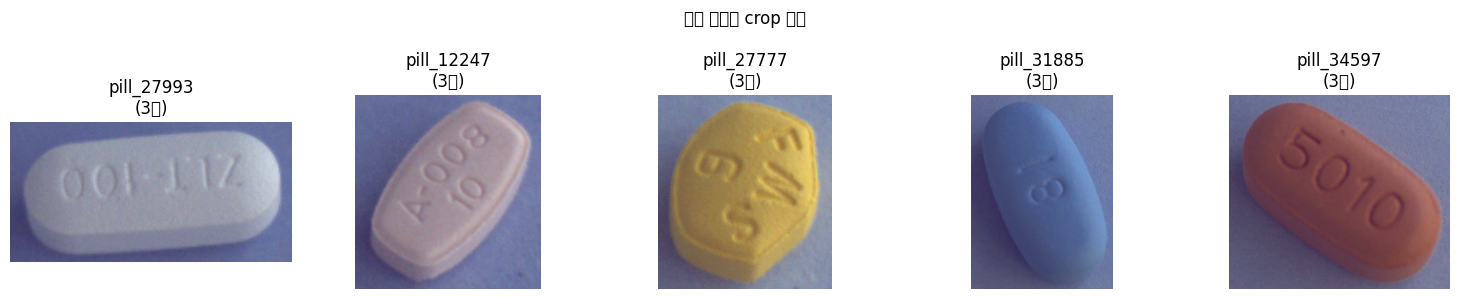

In [52]:
# 희귀 클래스 중 crop이 있는 것들만 5개 시각화
sample_classes = [cls for cls in rare_classes if len(rare_crops[cls]) > 0][:5]

fig, axes = plt.subplots(1, len(sample_classes), figsize=(3 * len(sample_classes), 3))
if len(sample_classes) == 1:
    axes = [axes]

for ax, cls in zip(axes, sample_classes):
    crop = rare_crops[cls][0].convert("RGB")
    ax.imshow(crop)
    ax.set_title(f"pill_{cls}\n({len(rare_crops[cls])}개)")
    ax.axis("off")

plt.suptitle("희귀 클래스 crop 샘플")
plt.tight_layout()
plt.show()

## 4. 희귀 클래스 포함 이미지 찾기

In [53]:
rare_set = set(rare_classes)

# 희귀 클래스가 포함된 이미지 목록
rare_images = {}
for fname, info in coco_data.items():
    rare_in_img = [lbl for lbl in info["labels"] if lbl in rare_set]
    if rare_in_img:
        rare_images[fname] = info

print(f"희귀 클래스 포함 이미지: {len(rare_images)}장 / 전체 {len(coco_data)}장")

# 3개 이하: 3배, 4~6개: 2배, 7~10개: 1배
def get_copy_count(cls):
    cnt = label_counter[cls]
    if cnt <= 3:
        return 3
    elif cnt <= 6:
        return 2
    else:
        return 1

print(f"\n복제 기준:")
print(f"  3개 이하:  3배 복제")
print(f"  4~6개:    2배 복제")
print(f"  7~10개:   1배 복제")

희귀 클래스 포함 이미지: 71장 / 전체 232장

복제 기준:
  3개 이하:  3배 복제
  4~6개:    2배 복제
  7~10개:   1배 복제


## 5. Augmentation 함수 정의

In [54]:
from PIL import ImageEnhance

def augment_image(img, boxes, aug_type):
    """
    이미지 + bbox를 함께 augmentation
    
    aug_type:
        "hflip"      - 좌우 반전
        "brightness"  - 밝기 변경
        "contrast"    - 대비 변경
        "rotate90"    - 90도 회전
    
    Returns: (augmented_img, augmented_boxes)
    """
    img_w, img_h = img.size
    new_boxes = []

    if aug_type == "hflip":
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        for x1, y1, x2, y2 in boxes:
            new_boxes.append([img_w - x2, y1, img_w - x1, y2])

    elif aug_type == "brightness":
        factor = random.uniform(0.7, 1.3)
        img = ImageEnhance.Brightness(img).enhance(factor)
        new_boxes = [list(b) for b in boxes]

    elif aug_type == "contrast":
        factor = random.uniform(0.7, 1.3)
        img = ImageEnhance.Contrast(img).enhance(factor)
        new_boxes = [list(b) for b in boxes]

    elif aug_type == "rotate90":
        img = img.rotate(-90, expand=True)
        for x1, y1, x2, y2 in boxes:
            new_boxes.append([img_h - y2, x1, img_h - y1, x2])

    return img, new_boxes

# augmentation 종류 목록
AUG_TYPES = ["hflip", "brightness", "contrast", "rotate90"]
print(f"Augmentation 종류: {AUG_TYPES}")

Augmentation 종류: ['hflip', 'brightness', 'contrast', 'rotate90']


## 6. 미리보기 (1장)

C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2383977643.py:27: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2383977643.py:27: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2383977643.py:27: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2383977643.py:27: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2383977643.py:27: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\YJ\AppData\Local\Temp\ipykernel_10496\2383977643.py:27: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans

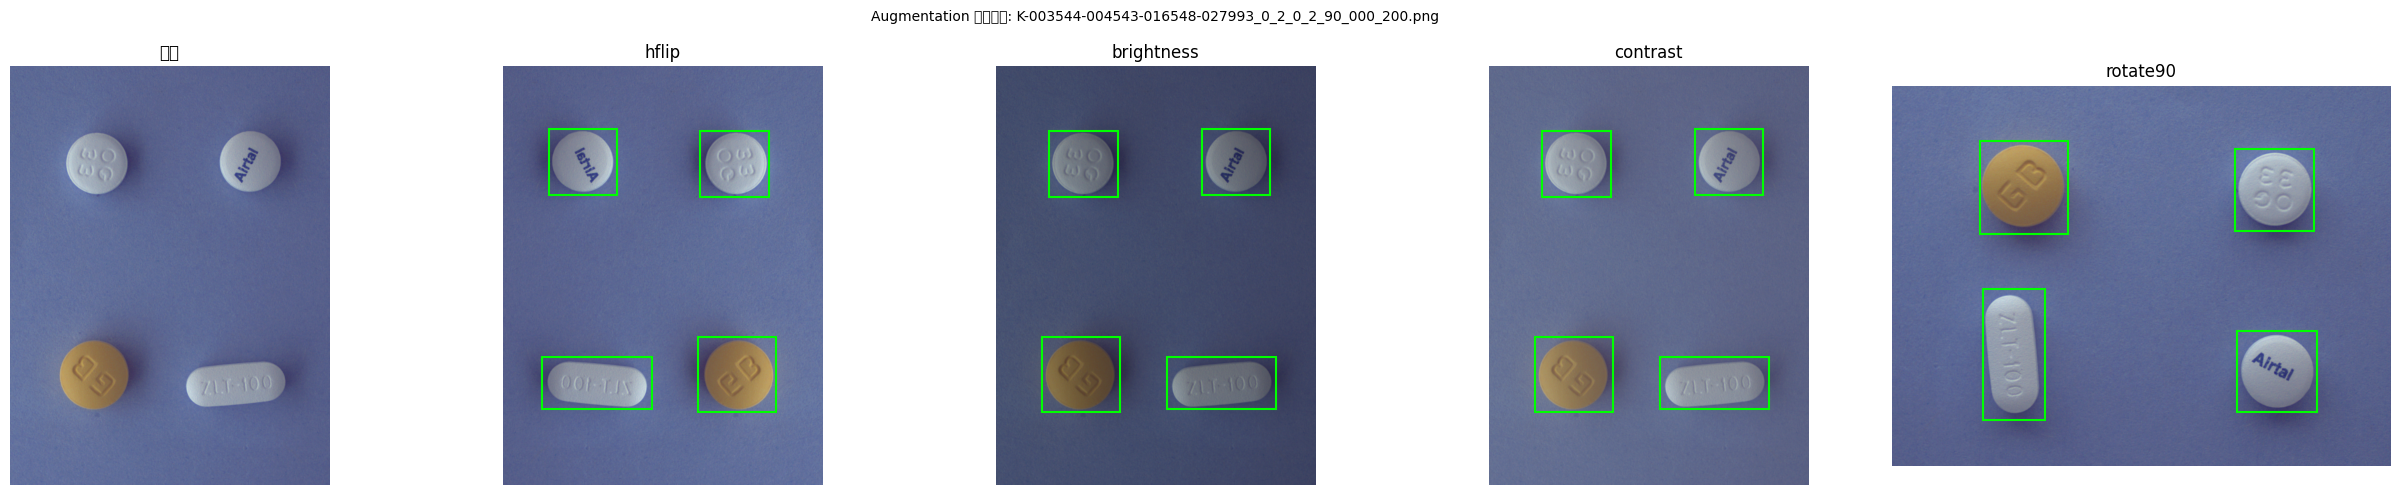

In [55]:
# 희귀 클래스 포함 이미지 1장으로 augmentation 미리보기
sample_fname = random.choice(list(rare_images.keys()))
sample_img = Image.open(TRAIN_IMG_DIR / sample_fname).convert("RGB")
sample_boxes = rare_images[sample_fname]["boxes"]
sample_labels = rare_images[sample_fname]["labels"]

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# 원본
axes[0].imshow(sample_img)
axes[0].set_title("원본")
axes[0].axis("off")

# 4가지 augmentation
for i, aug_type in enumerate(AUG_TYPES):
    aug_img, aug_boxes = augment_image(sample_img.copy(), sample_boxes, aug_type)
    axes[i+1].imshow(aug_img)
    for box in aug_boxes:
        x1, y1, x2, y2 = map(int, box)
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                  linewidth=1.5, edgecolor="lime", facecolor="none")
        axes[i+1].add_patch(rect)
    axes[i+1].set_title(aug_type)
    axes[i+1].axis("off")

plt.suptitle(f"Augmentation 미리보기: {sample_fname}", fontsize=10)
plt.tight_layout()
plt.show()

## 7. 오버샘플링 + Augmentation 실행 및 저장

In [56]:
SAVE_DIR = PROJECT_ROOT / "data" / "augmented"
SAVE_IMG_DIR = SAVE_DIR / "images"
SAVE_IMG_DIR.mkdir(parents=True, exist_ok=True)

aug_annotations = {}
count = 0

for fname, info in rare_images.items():
    img = Image.open(TRAIN_IMG_DIR / fname).convert("RGB")
    boxes = info["boxes"]
    labels = info["labels"]

    # 이 이미지의 희귀 클래스 중 가장 적은 클래스 기준으로 복제 횟수 결정
    rare_in_img = [lbl for lbl in labels if lbl in rare_set]
    max_copies = max(get_copy_count(lbl) for lbl in rare_in_img)

    # augmentation 종류를 랜덤으로 max_copies개 선택
    aug_picks = random.choices(AUG_TYPES, k=max_copies)

    for aug_type in aug_picks:
        aug_img, aug_boxes = augment_image(img.copy(), boxes, aug_type)

        save_name = f"aug_{count:04d}_{aug_type}.png"
        aug_img.save(SAVE_IMG_DIR / save_name)

        aug_annotations[save_name] = {
            "boxes": aug_boxes,
            "labels": labels,
            "width": aug_img.width,
            "height": aug_img.height,
            "source": fname,
            "aug_type": aug_type
        }
        count += 1

# 어노테이션 JSON 저장
with open(SAVE_DIR / "aug_annotations.json", "w", encoding="utf-8") as f:
    json.dump(aug_annotations, f, indent=2, ensure_ascii=False)

print(f"오버샘플링 + Augmentation 완료!")
print(f"생성된 이미지: {count}장")
print(f"저장 위치: {SAVE_IMG_DIR}")
print(f"어노테이션: {SAVE_DIR / 'aug_annotations.json'}")

오버샘플링 + Augmentation 완료!
생성된 이미지: 155장
저장 위치: c:\Users\YJ\Desktop\medicine\data\augmented\images
어노테이션: c:\Users\YJ\Desktop\medicine\data\augmented\aug_annotations.json


## 8. 증강 후 클래스 분포 확인

In [57]:
# 증강 데이터 클래스 카운트
aug_counter = Counter()
for fname, info in aug_annotations.items():
    for lbl in info["labels"]:
        aug_counter[lbl] += 1

print("=== 희귀 클래스 증강 결과 ===")
print(f"{'클래스':<15} {'원본':>6} {'증강':>6} {'합계':>6}")
print("-" * 40)

for cls in sorted(rare_classes):
    orig = label_counter[cls]
    aug = aug_counter.get(cls, 0)
    total = orig + aug
    print(f"pill_{cls:<10} {orig:>6} {aug:>6} {total:>6}")

print("-" * 40)
print(f"원본 이미지: {len(coco_data)}장")
print(f"증강 이미지: {len(aug_annotations)}장")
print(f"학습용 합계: {len(coco_data) + len(aug_annotations)}장")

=== 희귀 클래스 증강 결과 ===
클래스                 원본     증강     합계
----------------------------------------
pill_2483            9     27     36
pill_3544            6     18     24
pill_3743            3      9     12
pill_4543            5     15     20
pill_12081           3      9     12
pill_12247           3      9     12
pill_12778           6     18     24
pill_13395           3      9     12
pill_16551           3      9     12
pill_16688           8      8     16
pill_19552           3      9     12
pill_19607           6     18     24
pill_19861           6     12     18
pill_21771           3      9     12
pill_22347           9     15     24
pill_22362           3      9     12
pill_24850           3      9     12
pill_25438           6     18     24
pill_27777           3      9     12
pill_27926           3      9     12
pill_27993           3      9     12
pill_28763           9     12     21
pill_29345           6     18     24
pill_29451           3      9     12
pill_30308   

In [58]:
import shutil

MERGED_DIR = PROJECT_ROOT / "data" / "train_merged"
MERGED_IMG_DIR = MERGED_DIR / "images"
MERGED_IMG_DIR.mkdir(parents=True, exist_ok=True)

# 1) 원본 이미지 복사
print("원본 이미지 복사 중...")
orig_count = 0
for fname in coco_data.keys():
    src = TRAIN_IMG_DIR / fname
    dst = MERGED_IMG_DIR / fname
    if src.exists() and not dst.exists():
        shutil.copy2(src, dst)
        orig_count += 1
print(f"  원본: {orig_count}장 복사")

# 2) 증강 이미지 복사
print("증강 이미지 복사 중...")
aug_count = 0
for fname in aug_annotations.keys():
    src = SAVE_IMG_DIR / fname
    dst = MERGED_IMG_DIR / fname
    if src.exists() and not dst.exists():
        shutil.copy2(src, dst)
        aug_count += 1
print(f"  증강: {aug_count}장 복사")

# 3) 병합 어노테이션 생성
merged_coco = {}

# 원본 데이터
for fname, info in coco_data.items():
    merged_coco[fname] = {
        "boxes": info["boxes"],
        "labels": info["labels"],
        "width": info["width"],
        "height": info["height"]
    }

# 증강 데이터
for fname, info in aug_annotations.items():
    merged_coco[fname] = {
        "boxes": info["boxes"],
        "labels": info["labels"],
        "width": info["width"],
        "height": info["height"]
    }

# 저장
merged_json_path = MERGED_DIR / "merged_coco_data.json"
with open(merged_json_path, "w", encoding="utf-8") as f:
    json.dump(merged_coco, f, indent=2, ensure_ascii=False)

print(f"\n병합 완료!")
print(f"  원본: {len(coco_data)}장")
print(f"  증강: {len(aug_annotations)}장")
print(f"  합계: {len(merged_coco)}장")
print(f"\n저장 위치:")
print(f"  이미지: {MERGED_IMG_DIR}")
print(f"  어노테이션: {merged_json_path}")

원본 이미지 복사 중...
  원본: 0장 복사
증강 이미지 복사 중...
  증강: 52장 복사

병합 완료!
  원본: 232장
  증강: 155장
  합계: 387장

저장 위치:
  이미지: c:\Users\YJ\Desktop\medicine\data\train_merged\images
  어노테이션: c:\Users\YJ\Desktop\medicine\data\train_merged\merged_coco_data.json


## 9. 병합 데이터셋 생성 (원본 보존)

원본 `data/raw/train_images/`는 그대로 유지하고,  
`data/train_merged/`에 원본 + 증강 이미지를 합쳐서 별도 저장합니다.

## 10. YOLO 데이터셋 변환 (증강 포함)

`merged_coco_data.json` → YOLO 포맷으로 변환  
기존 `dataset/yolo_dataset/`은 보존, 새로 `dataset/yolo_dataset_aug/`에 저장

In [59]:
import os
import yaml
from tqdm import tqdm

# === 설정 ===
MERGED_JSON = PROJECT_ROOT / "data" / "train_merged" / "merged_coco_data.json"
MERGED_IMG = PROJECT_ROOT / "data" / "train_merged" / "images"
YOLO_AUG_ROOT = PROJECT_ROOT / "dataset" / "yolo_dataset_aug"
SPLIT_INFO = PROJECT_ROOT / "dataset" / "yolo_dataset" / "split_info.json"

# 병합 데이터 로드
with open(MERGED_JSON, "r", encoding="utf-8") as f:
    merged_data = json.load(f)

# 기존 split 정보 로드 (원본 val 47장)
with open(SPLIT_INFO, "r", encoding="utf-8") as f:
    split_info = json.load(f)

val_imgs = split_info["val"]        # 원본 val 47장 (그대로 유지)
orig_train = split_info["train"]    # 원본 train 185장

# train = 원본 train + 증강 이미지 전부
aug_imgs = [f for f in merged_data.keys() if f.startswith("aug_")]
train_imgs = orig_train + aug_imgs

print(f"병합 데이터: {len(merged_data)}장")
print(f"Val: {len(val_imgs)}장 (원본만, 증강 없음)")
print(f"Train: {len(train_imgs)}장 (원본 {len(orig_train)} + 증강 {len(aug_imgs)})")

# === 1) 폴더 생성 ===
if YOLO_AUG_ROOT.exists():
    shutil.rmtree(YOLO_AUG_ROOT)
    print("기존 yolo_dataset_aug 삭제 후 재생성")

for mode in ["train", "val"]:
    (YOLO_AUG_ROOT / "images" / mode).mkdir(parents=True, exist_ok=True)
    (YOLO_AUG_ROOT / "labels" / mode).mkdir(parents=True, exist_ok=True)

# === 2) 클래스 매핑 ===
all_labels = set()
for info in merged_data.values():
    all_labels.update(info["labels"])

sorted_label_ids = sorted(list(all_labels))
label_map = {orig_id: i for i, orig_id in enumerate(sorted_label_ids)}
print(f"클래스 수: {len(sorted_label_ids)}개")

# === 3) YOLO 포맷 변환 + 저장 ===
def convert_box_to_yolo(box, img_w, img_h):
    x1, y1, x2, y2 = box
    cx = (x1 + x2) / 2.0 / img_w
    cy = (y1 + y2) / 2.0 / img_h
    w = (x2 - x1) / img_w
    h = (y2 - y1) / img_h
    return cx, cy, w, h

for mode, img_list in [("train", train_imgs), ("val", val_imgs)]:
    print(f"{mode} 변환 중...")
    for img_name in tqdm(img_list):
        if img_name not in merged_data:
            continue
        info = merged_data[img_name]
        img_w, img_h = info["width"], info["height"]

        # 이미지 복사
        src = MERGED_IMG / img_name
        dst = YOLO_AUG_ROOT / "images" / mode / img_name
        if src.exists():
            shutil.copy2(src, dst)

        # 라벨 파일 생성
        label_name = os.path.splitext(img_name)[0] + ".txt"
        with open(YOLO_AUG_ROOT / "labels" / mode / label_name, "w") as f:
            for box, orig_label in zip(info["boxes"], info["labels"]):
                yolo_box = convert_box_to_yolo(box, img_w, img_h)
                new_id = label_map[orig_label]
                f.write(f"{new_id} {' '.join([f'{v:.6f}' for v in yolo_box])}\n")

# === 4) data.yaml 생성 ===
yaml_content = {
    "path": str(YOLO_AUG_ROOT),
    "train": "images/train",
    "val": "images/val",
    "nc": len(sorted_label_ids),
    "names": {i: f"pill_{orig_id}" for i, orig_id in enumerate(sorted_label_ids)}
}
with open(YOLO_AUG_ROOT / "data.yaml", "w") as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print(f"\nYOLO 변환 완료!")
print(f"Train: {len(train_imgs)}장 (원본 + 증강)")
print(f"Val: {len(val_imgs)}장 (원본만)")
print(f"data.yaml: {YOLO_AUG_ROOT / 'data.yaml'}")

병합 데이터: 387장
Val: 47장 (원본만, 증강 없음)
Train: 340장 (원본 185 + 증강 155)
기존 yolo_dataset_aug 삭제 후 재생성
클래스 수: 56개
train 변환 중...


100%|██████████| 340/340 [00:00<00:00, 540.84it/s]


val 변환 중...


100%|██████████| 47/47 [00:00<00:00, 497.08it/s]


YOLO 변환 완료!
Train: 340장 (원본 + 증강)
Val: 47장 (원본만)
data.yaml: c:\Users\YJ\Desktop\medicine\dataset\yolo_dataset_aug\data.yaml
